# Description

MasterClass started a subscription model. You are asked to help executives understand how the subscription model is doing.

In particular, your boss is interested in:

1. A model that predicts monthly retention rate for the different subscription price points

2. Based on your model, for each price point, what percentage of users is still subscribed after at least 12 months?

3. How do user country and source affect subscription retention rate? How would you use these findings to improve the company revenue?

# Data

The table is:

subscription - gives information about the user and her subscription status

Columns:

* user_id : the id of the user. Unique by user.
* subscription_signup_date : when the user signed up for the subscription. It is always Jan, 2015 in this table.
* subscription_monthly_cost : how much the user pays each month for the subscription (USD)
* source : marketing acquisition channel (SEO/Ads/Friend Referral)
* billing_cycles : total billing cycles as of the end of August.
* is_active : whether the subscription is still active (1) or not (0). If billing cycles is 8, it means the user has still an active subscription.

### Read data

In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pandas.set_option('display.max_columns', 10)
pandas.set_option('display.width', 350)
  

data = pandas.read_csv("https://drive.google.com/uc?export=download&id=1uH3Gpzam1pAfhdHIJd9UqraBS009wDer")
  
print(data.head())

   user_id subscription_signup_date  subscription_monthly_cost  country source  billing_cycles  is_active
0     1459            January, 2015                         29    Spain    ads               4          0
1    12474            January, 2015                         49   France    ads               5          0
2    12294            January, 2015                         49  Germany    ads               2          0
3     3878            January, 2015                         49    China    ads               1          0
4     9567            January, 2015                         49       UK    ads               5          0


### Q: A model that predicts monthly retention rate for the different subscription price points

The standard approach to this is:

1. Try to see if the relationship is linear. If yes, build a linear regression and you are done.

2. If the relationship is not linear, try to see if some standard non-linear transformation of the variables can lead to a linear relationship

3. Else, use a more flexible model like GAM, which would be at least as good as regression.

However, while this is true from a statistical standpoint, from a product standpoint there are significant advantages in using a linear regression when it comes to communicating work to non-technical people.

#### Group data points

In [2]:
retention_rate_data_points = data.groupby(['subscription_monthly_cost', 'billing_cycles']).size().reset_index(name = 'tmp_count_billing')
retention_rate_data_points

,subscription_monthly_cost,billing_cycles,tmp_count_billing
0,29,1,57441
1,29,2,21818
2,29,3,12037
3,29,4,7787
4,29,5,5505
5,29,6,4136
6,29,7,3111
7,29,8,34527
8,49,1,185145
9,49,2,53296


#### Estimate retention rate

In [3]:
# churn rate = cumulative sum by billing cycle / total users 
# retention rate = 1 - churn_rate 
retention_rate_data_points['retention_rate'] = retention_rate_data_points.groupby('subscription_monthly_cost')['tmp_count_billing'].transform(lambda x: 1-x.cumsum()/x.sum())
retention_rate_data_points

,subscription_monthly_cost,billing_cycles,tmp_count_billing,retention_rate
0,29,1,57441,0.607542
1,29,2,21818,0.458473
2,29,3,12037,0.376232
3,29,4,7787,0.323028
4,29,5,5505,0.285416
5,29,6,4136,0.257157
6,29,7,3111,0.235901
7,29,8,34527,0.000000
8,49,1,185145,0.383666
9,49,2,53296,0.206247


#### Drop values

In [ ]:
# remove tmp_count_billing column and billing cycle == 8 because those are still active
retention_rate_data_points = retention_rate_data_points.drop('tmp_count_billing', 1).query('billing_cycles < 8')

#### Visualisation and insights

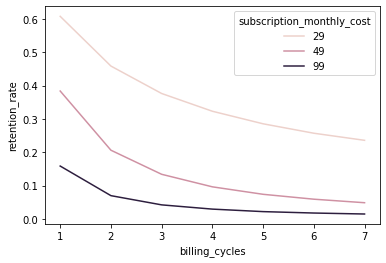

In [ ]:
sns.lineplot(x="billing_cycles", y="retention_rate", hue="subscription_monthly_cost", data=retention_rate_data_points, legend="full")
plt.show()

The relationship is clearly non-linear for all price points. The speed of decay seems to slow down as the x-axis increase.

In [ ]:
print(retention_rate_data_points.query('subscription_monthly_cost==29'))

   subscription_monthly_cost  billing_cycles  retention_rate
0                         29               1        0.607542
1                         29               2        0.458473
2                         29               3        0.376232
3                         29               4        0.323028
4                         29               5        0.285416
5                         29               6        0.257157
6                         29               7        0.235901


For the cheapest price point, 40% of people churn after only 1 billing cycle, 15% after 2, 8% after 3, and so on. 

In a situation like this, a logarithm transformation can help make the relationship linear. 

Also, retention rate cannot be negative. Using log(billing_cycle) and log(retention_rate) in the regressions as variables should therefore help both ways: make the relationship more linear and make sure retention won’t be negative.

In [ ]:
retention_rate_data_points["billing_log"] = np.log(retention_rate_data_points["billing_cycles"])
retention_rate_data_points["retention_rate_log"] = np.log(retention_rate_data_points["retention_rate"])

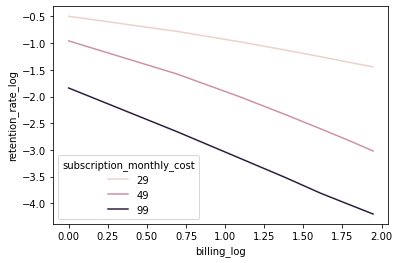

In [ ]:
sns.lineplot(x="billing_log", y="retention_rate_log", hue="subscription_monthly_cost", data=retention_rate_data_points, legend="full")
plt.show()

Now it looks much more linear. A linear regression is now suitable.

In [ ]:
import statsmodels.api as sm

#### Build linear model for price 29

In [ ]:
y29 = retention_rate_data_points.query('subscription_monthly_cost==29')['retention_rate_log']
X29 = retention_rate_data_points.query('subscription_monthly_cost==29')['billing_log']
X29 = sm.add_constant(X29)

In [ ]:
model29 = sm.OLS(y29, X29)
results29 = model29.fit()
print("R Squared for 29$ is:", round(results29.rsquared,2))

R Squared for 29$ is: 0.99


#### Build linear model for price 49

In [ ]:
y49 = retention_rate_data_points.query('subscription_monthly_cost==49')['retention_rate_log']
X49 = retention_rate_data_points.query('subscription_monthly_cost==49')['billing_log']
X49 = sm.add_constant(X49)
  
model49 = sm.OLS(y49, X49)
results49 = model49.fit()
print("R Squared for 49$ is:", round(results49.rsquared,2))

R Squared for 49$ is: 1.0


#### Build linear model for price 99

In [ ]:
y99 = retention_rate_data_points.query('subscription_monthly_cost==99')['retention_rate_log']
X99 = retention_rate_data_points.query('subscription_monthly_cost==99')['billing_log']
X99 = sm.add_constant(X99)
  
model99 = sm.OLS(y99, X99)
results99 = model99.fit()
print("R Squared for 99$ is:", round(results99.rsquared,2))

R Squared for 99$ is: 1.0


## Q: Based on your model, for each price point, what percentage of users is still subscribed after at least 12 months?

Now we can simply feed the regression with billing cycles up to 12 and get the output.

In [ ]:
Xpred = np.log(range(8,13))
Xpred = sm.add_constant(Xpred)
print(results29.predict(Xpred))

[-1.48549968 -1.54324007 -1.5948906  -1.64161419 -1.68426949]


However, our regression is actually predicting log(retention_rate). To get retention rate, we need to take the exponential of those predictions

In [ ]:
print(np.exp(results29.predict(Xpred)))

[0.22638919 0.21368762 0.20293073 0.19366717 0.18557995]


In [ ]:
print("For the 29$ price point, after 1 year, we will retain", round(np.exp(results29.predict(Xpred))[4], 3), "of our customers")

For the 29$ price point, after 1 year, we will retain 0.186 of our customers


In [ ]:
print("For the 49$ price point, after 1 year, we will retain", round(np.exp(results49.predict(Xpred))[4], 3), "of our customers")

For the 49$ price point, after 1 year, we will retain 0.029 of our customers


In [ ]:
print("For the 99$ price point, after 1 year, we will retain", round(np.exp(results99.predict(Xpred))[4], 3), "of our customers")

For the 99$ price point, after 1 year, we will retain 0.008 of our customers


#### Customer LTV

For each price point, let’s get the average customer one year value. This can be defined as customer LTV.

In [ ]:
# the models work well enough that we can directly use their predictions for all 12 billing cycle to estimate customer LTV.
  
Xpred = np.log(range(1,13))
Xpred = sm.add_constant(Xpred)

For 29$/month

In [ ]:
# get retention rate for each billing cycle
retention_rate_tmp = np.exp(results29.predict(Xpred))

# then get overall expected value by multiplying each probability * corresponding money at each billing cycle.
LTV_29 = 29 + sum(retention_rate_tmp * 29)
print("Avg LTV of customers paying 29$ a month is:", round(LTV_29), "dollars")

Avg LTV of customers paying 29$ a month is: 132 dollars


For 49$/month

In [ ]:
retention_rate_tmp = np.exp(results49.predict(Xpred))
LTV_49 = 49 + sum(retention_rate_tmp * 49)
print("Avg LTV of customers paying 49$ a month is:", round(LTV_49), "dollars")

Avg LTV of customers paying 49$ a month is: 107 dollars


In [ ]:
retention_rate_tmp = np.exp(results99.predict(Xpred))
LTV_99 = 99 + sum(retention_rate_tmp * 99)
print("Avg LTV of customers paying 99$ a month is:", round(LTV_99), "dollars")

Avg LTV of customers paying 99$ a month is: 139 dollars


Therefore, the highest LTV is for users paying 99 dollars. 

However, considering that 29 has a much higher 1 year retention rate, if we had taken a larger time window to define LTV, 29 would have likely been the best one.

## Q: How do user country and source affect subscription retention rate? How would you use these findings to improve the company revenue?

As a first step, let’s see the proportion of users that are still active after 8 months for the different price points by country and source to see if there are any major differences.

### Group by country

In [ ]:
country_retention = data.groupby(['country', 'subscription_monthly_cost']).apply(lambda x: pandas.Series({
                             # active users
                            'retention_rate': x['is_active'].mean(),
                             # total count by price and country
                            'count': x['is_active'].count(),
                            # avg revenue by price and country
                            'revenue' : (x['subscription_monthly_cost'] * x['billing_cycles']).mean()
})).reset_index()

#### Plot country vs retention rate, categorised by price

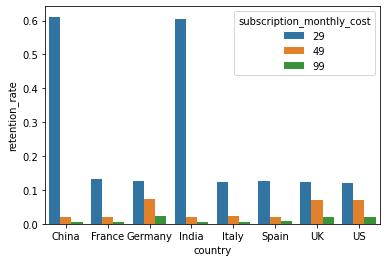

In [ ]:
sns.barplot(x="country", hue="subscription_monthly_cost", y="retention_rate", data=country_retention)
plt.show()

#### Plot country vs revenue, categorised by price

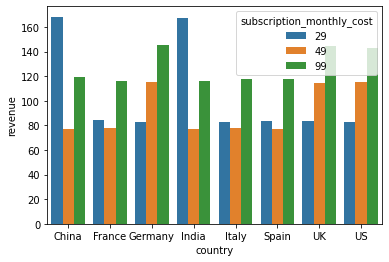

In [ ]:
sns.barplot(x="country", hue="subscription_monthly_cost", y="revenue", data=country_retention)
plt.show()

#### Findings

China and India have huge retention rate for the cheapest price point. A deep dive would be useful to understand why. They are also much more likely to choose the 29$ option compared to the other countries

For India and China, the best price point is the cheapest one. For all other countries, the best price point is the most expensive one. However, unfortunately, all countries have the highest proportion of subscribers for the middle price. This is exactly the opposite of what we would like to have.

If we could shift users towards the optimal price point, this would increase user LTV, and that would have several positive effects, beside the obvious revenue gain. For instance, higher LTV means that we could bid higher for ads, and therefore grow much faster.

The goal is essentially to make given price points more attractive on a country basis. A way to achieve this would be to change the UI so that, for each country, the optimal price point is more prominent.

Another approach could be to look into how users from each country are using the product. Figure out what they like the most and then play around with each price point features in such a way that the best price has the most attractive features for each country.

Another approach could be targeted/regional coupons.

The good news is that, although retention is a long term metric, it is actually very easy to predict long term retention just by looking at the first month or so. That makes so much easier to run A/B tests and iterate fast.

### Group by source

In [ ]:
source_retention = data.groupby(['source', 'subscription_monthly_cost']).apply(lambda x: pandas.Series({
                             # active users
                            'retention_rate': x['is_active'].mean(),
                             # total count by price and source
                            'count': x['is_active'].count(),
                            # avg revenue by price and source
                            'revenue' : (x['subscription_monthly_cost'] * x['billing_cycles']).mean()
})).reset_index()

#### Plot source vs retention rate, categorised by price

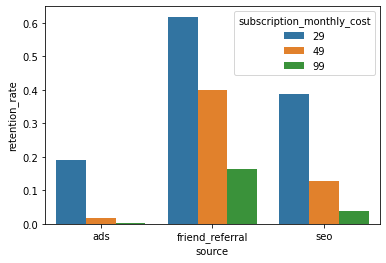

In [ ]:
sns.barplot(x="source", hue="subscription_monthly_cost", y="retention_rate", data=source_retention)
plt.show()

### Plot source vs count, categorised by price

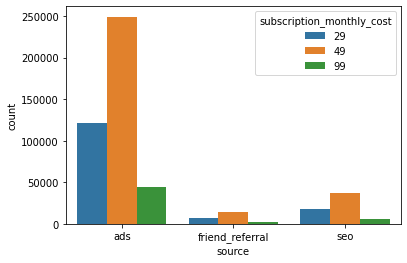

In [ ]:
sns.barplot(x="source", hue="subscription_monthly_cost", y="count", data=source_retention)
plt.show()

### Plot source vs avg user revenue, categorised by price

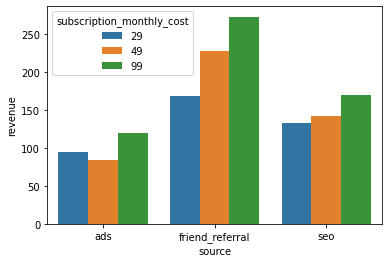

In [ ]:
sns.barplot(x="source", hue="subscription_monthly_cost", y="revenue", data=source_retention)
plt.show()

### Findings

The high majority of users are coming from ads. Unfortunately, these users have the lowest retention and, consequently, the lowest LTV. Even worse, those ads are mainly attracting 49$ customers. That’s highly inefficient. Ads campaigns should be optimized to attract customers with higher likelihood of buying the optimal price point


Friend referrals are doing really well, but have very low absolute numbers. Increasing this is a big opportunity. And the discount that is usually given to referred users can also be used as a leverage for the price discussion from above.


SEO is also doing better than ads in terms of retention, but there are way less users. This is also a big opportunity, especially because SEO is the only one that doesn’t cost anything.